In [126]:
import pandas as pd
import numpy as np
import sklearn
from collections import Counter
from itertools import dropwhile
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import csv
import pickle


print("Import Complete")

Import Complete


In [127]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [128]:
def build_vocabulary(messages, word_drop=True):
    cvocabularies = Counter()
    #print("building vocabulary from {} messages".format(len(messages)))
    for start in range(0, len(messages), 500):
        vocabulary = Counter()
        for message in messages[start:start + 500]:
            message = str(message)
            #message = remove_nonalphanumeric(message)
            message_split = message.split()
            gram_count = 3
            grams = []
            for i in range(len(message_split) - (gram_count - 1)):
                gram = ''
                for n in range(gram_count):
                    gram = gram + message_split[i+n] + ' '
                grams.append(gram[:-1])
            vocabulary = vocabulary + Counter(message_split) + Counter(grams)
        cvocabularies = cvocabularies + vocabulary
    if word_drop == True:
        for key, count in dropwhile(
                                    lambda key_count: key_count[1] >= (len(messages) * .01),
                                    cvocabularies.most_common()):
            del cvocabularies[key]
    #print("The vocabulary contains {} words".format(len(cvocabularies)))
    return cvocabularies

In [129]:
def feature_list(file):
    vocab = []
    with open(file, 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            word = row[0]
            if word not in vocab:
                vocab.append(word)
            else:
                print("Repeat: {}".format(word))
    return vocab

def label_features(df, features_master):
        for i,row in df.iterrows():
            #message = pruning_dict.remove_nonalphanumeric(row.text)
            message = str(row.question_class)
            features = build_vocabulary([message], word_drop=False) & features_master
            features = features + features_master
            features = list(np.array(list(features.values())) - 1)
            df.set_value(i,'features',features)
        return df

def create_feature_dataframe(df, features_master):
    return pd.DataFrame(list(df.features), columns=range(len(features_master)))

def cluster_filter2(df, df2, N, features_master, v=False):
    #print("Start loop")
    #gpercentages = []
    #singles = 0
    clusterer = KMeans(n_clusters=N)
    clusterer.fit(df2)
    transform = clusterer.transform(df2)
    
    
    d_center = []
    cluster = []
    for x in transform:
        d_center.append(min(x)**2)
        cluster.append(np.argmin(x))
    df['cluster'] = cluster
    df['d_from_center'] = d_center
    d_center = np.array(d_center)
    mean = np.mean(d_center)
    std = np.std(d_center)
    silhouette_avg = silhouette_score(df2, df.cluster)
    calinski = calinski_harabaz_score(df2, df.cluster)
    print("Silhouette: {}".format(round(silhouette_avg,3)))
    print("Calinski_Harabaz: {}".format(round(calinski, 3)))
    print("Mean: {}".format(round(mean, 3)))
    print("STD: {}".format(round(std, 3)))
    print("")

    
    '''
    for cgroup in range(N):
        group = df.groupby('cluster').get_group(cgroup)
        if group.question_class.count() <= len(df) * .01:
            df = df.drop(group.index)
            singles += 1
    print("# of singles: {}".format(singles))
    print("df length: {}".format(len(df)))
    if singles >= 6 and N <= (len(df) - singles):
        df = cluster_filter2(df, create_feature_dataframe(df, features_master), N, features_master)
        return df

    for cgroup in range(N):
        group = df.groupby('cluster').get_group(cgroup)
        gpercent = (compute_gpercentage(group, mean, std))
        gpercentages.append(gpercent)


        if v == True:
            print("Found {} messages of the same form with a gpercent of {}.".format(len(group), gpercent))
            for message in group.question_class.head(3):
                if group.question_class.count() > 1:
                    print(message)
                    print("")

            
    
    #median = np.median(np.array(gpercentages))
    '''
    if v == True:
        for cgroup in range(N):
            group = df.groupby('cluster').get_group(cgroup)
            print_clusters(group)
    else:
        pass
        #print(median)
        #print(np.mean(np.array(gpercentages)))
    
    return df, silhouette_avg

def compute_gpercentage(group, mean, std):

    gscore = 0.0
    for i, row in group.iterrows():
        z = (row.d_from_center - mean) / std
        if z < -0.68:
            gscore += 1
    glength = len(group)
    gpercent = gscore/glength
    return gpercent

def print_clusters(group):
    print("Found {} messages of the same form.".format(len(group)))
    for message in group.question_class.head(5):
        if group.question_class.count() > 1:
            print(message)
            print("")
    print("")
            
    
    

C:\Users\kerri\Anaconda2\envs\thinkhr\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


N: 10
Silhouette: 0.039
Calinski_Harabaz: 98.957
Mean: 3.311
STD: 2.916

N: 11
Silhouette: 0.062
Calinski_Harabaz: 97.396
Mean: 3.265
STD: 2.748

N: 12
Silhouette: 0.052
Calinski_Harabaz: 94.457
Mean: 3.23
STD: 2.75

N: 13
Silhouette: 0.05
Calinski_Harabaz: 88.764
Mean: 3.216
STD: 2.725

N: 14
Silhouette: 0.053
Calinski_Harabaz: 85.863
Mean: 3.189
STD: 2.736

N: 15
Silhouette: 0.045
Calinski_Harabaz: 84.829
Mean: 3.152
STD: 2.727

N: 16
Silhouette: 0.053
Calinski_Harabaz: 81.29
Mean: 3.135
STD: 2.653

N: 17
Silhouette: 0.045
Calinski_Harabaz: 77.078
Mean: 3.128
STD: 2.703

N: 18
Silhouette: 0.043
Calinski_Harabaz: 75.388
Mean: 3.104
STD: 2.639

N: 19
Silhouette: 0.045
Calinski_Harabaz: 73.731
Mean: 3.081
STD: 2.684

N: 20
Silhouette: 0.027
Calinski_Harabaz: 71.39
Mean: 3.067
STD: 2.682

N: 21
Silhouette: 0.046
Calinski_Harabaz: 68.564
Mean: 3.06
STD: 2.64

N: 22
Silhouette: 0.037
Calinski_Harabaz: 67.969
Mean: 3.033
STD: 2.673

N: 23
Silhouette: 0.017
Calinski_Harabaz: 65.903
Mean: 3.0

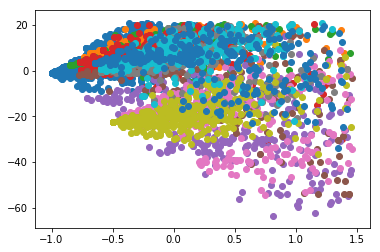

In [132]:
csvdata = "./data/subcategory_2_think_hr_v2.csv"
df = pd.read_csv(csvdata)
df = df[['question_class']][:5000]

#vocab = feature_list('./HotWords.csv')
vocab = load_obj('final_feature_set')

features_master = Counter(vocab)
df["features"] = [[0] * len(vocab)] * len(df)
df = label_features(df, features_master)
df2 = create_feature_dataframe(df, features_master)

svd = TruncatedSVD(n_components=75, n_iter=50, random_state=42)
df2 = svd.fit_transform(df2)


medians = []
for N in range(10,35):
    print("N: {}".format(N))
    df, median = cluster_filter2(df, df2, N, features_master)
    medians.append([median, N])

best_clustering_index = np.argmax(medians, axis=0)
best_clustering = medians[best_clustering_index[0]][1]
print("The best clustering is {}:".format(best_clustering))
df, median = cluster_filter2(df, df2, best_clustering, features_master, v=True)

svd = TruncatedSVD(n_components=2, n_iter=2, random_state=42)
df["plot_cord"] = list(svd.fit_transform(df2))

#df2 = create_feature_dataframe(df, features_master)
transformed = pd.DataFrame(svd.fit_transform(df2), columns=["plot_cordX", "plot_cordY"])
meanX = transformed["plot_cordX"].mean()
meanY = transformed["plot_cordY"].mean()
transformed["plot_cordX"] = transformed["plot_cordX"].divide(meanX) - 1
transformed["plot_cordY"] = transformed["plot_cordY"].divide(meanY) - 1
meanX = transformed["plot_cordX"].mean()



df["plot_cordX"] = transformed.plot_cordX
df["plot_cordY"] = transformed.plot_cordY

q = df["plot_cordX"].quantile(0.95)
df = df[df["plot_cordX"] < q]
q = df["plot_cordY"].quantile(0.95)
df = df[df["plot_cordY"] < q]


for n in range(best_clustering):
    plt.scatter(df[df["cluster"] == n].plot_cordX, df[df["cluster"] == n].plot_cordY, label="Class " + str(n))



#plt.legend()
plt.show()

